In [1]:
import QuasinormalMode
from QuasinormalMode import *
import Waveforms
from Waveforms import *
import Fit
from Fit import *
import utils
from utils import *
import plot
from plot import *
import ModeSelection
from ModeSelection import *
import postprocess
from postprocess import *
import GRChombo_load
from GRChombo_load import *
from importlib import reload
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft

2023-05-02 10:29:18.151930: W external/org_tensorflow/tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/shared/apps/slurm/current/lib64/slurm:/cm/shared/apps/slurm/current/lib64
2023-05-02 10:29:19.219464: W external/org_tensorflow/tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/shared/apps/slurm/current/lib64/slurm:/cm/shared/apps/slurm/current/lib64
2023-05-02 10:29:19.324535: W external/org_tensorflow/tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIB

In [2]:
from importlib import reload

In [3]:
reload(QuasinormalMode)
from QuasinormalMode import *
reload(Waveforms)
from Waveforms import *
reload(plot)
from plot import *
reload(ModeSelection)
from ModeSelection import *
reload(Fit)
from Fit import *

In [4]:
from pycbc.waveform.waveform_modes import sum_modes

In [5]:
iota = np.pi/3
psi = 0
SXS_num = "1485"
h, Mf, af, retro = get_SXS_waveform_summed(SXS_num, iota, psi)

Skipping download from 'https://data.black-holes.org/catalog.json' because local file is newer
Skipping download from 'https://data.black-holes.org/catalog.json' because local file is newer
Found the following files to load from the SXS catalog:
    SXS:BBH:1485v5/Lev3/rhOverM_Asymptotic_GeometricUnits_CoM.h5
Found the following files to load from the SXS catalog:
    SXS:BBH:1485v5/Lev3/metadata.json


2023-05-02 10:30:16.385257: W external/org_tensorflow/tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/shared/apps/slurm/current/lib64/slurm:/cm/shared/apps/slurm/current/lib64
2023-05-02 10:30:16.385300: W external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)


In [6]:
t0_arr = np.linspace(0,30,num=501)
N_free = 3
qnm_fixed_list = []
full_fit = QNMFitVaryingStartingTime(h, t0_arr, N_free, qnm_fixed_list,
                                     run_string_prefix=f"SXS{SXS_num}_summed_{iota:.4f}_{psi:.4f}")

In [7]:
full_fit.do_fits()

reloaded fit SXS1485_summed_1.0472_0.0000_N_3_t0_0.0000_30.0000_501 from an old run.


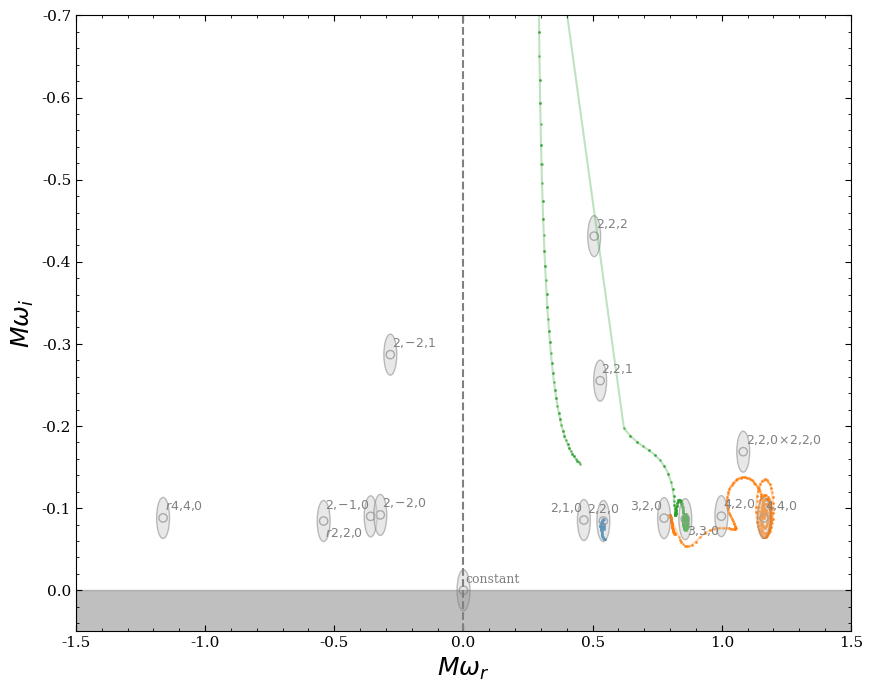

In [8]:
fig, ax = plt.subplots(figsize = (10, 8))
ax.set_xlim(-1.5, 1.5)
predicted_qnm_list = long_str_to_qnms("-4.4.0_2.1.0_2.-1.0_2.2.0_2.2.1_2.2.2_3.2.0_2.-2.1_-2.2.0_3.3.0_"
                                      "4.2.0_4.4.0_2.-2.0_2.2.0x2.2.0_constant", Mf, af)
plot_omega_free(full_fit.result_full, ax = ax)
plot_predicted_qnms(ax, predicted_qnm_list)

In [9]:
t0_arr = np.linspace(0,50,num=501)
N_free = 0
qnm_fixed_list = long_str_to_qnms("-2.2.0_2.2.0_-3.3.0_3.3.0", Mf, af) 
full_fit_fixed = QNMFitVaryingStartingTime(h, t0_arr, N_free, qnm_fixed_list,
                                     run_string_prefix=f"SXS{SXS_num}_summed_{iota:.4f}_{psi:.4f}")

In [10]:
full_fit_fixed.do_fits()

reloaded fit SXS1485_summed_1.0472_0.0000_N_0_fix_-2.2.0_-3.3.0_2.2.0_3.3.0_t0_0.0000_50.0000_501 from an old run.


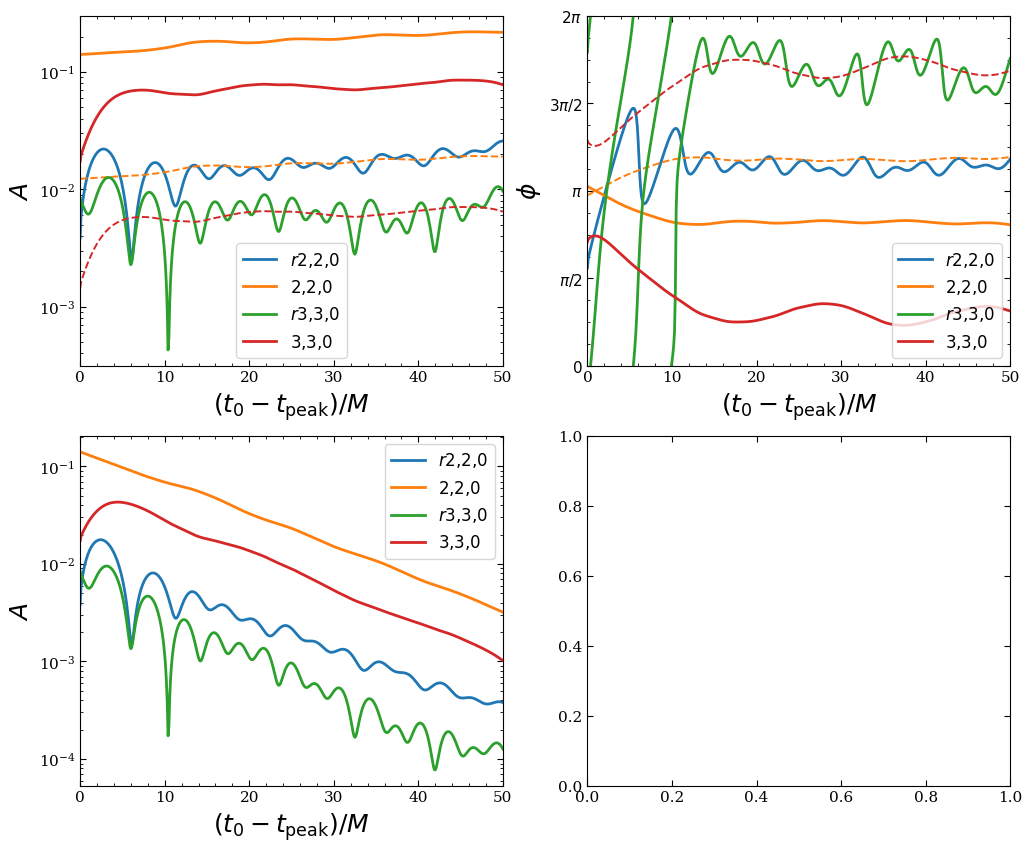

In [11]:
fig, axs = plt.subplots(2,2, figsize = (12, 10))
plot_amplitudes_unadj(full_fit_fixed.result_full, fixed_modes=qnm_fixed_list, ax = axs[1,0])
plot_amplitudes(full_fit_fixed.result_full, fixed_modes=qnm_fixed_list, ax = axs[0,0],
                plot_retro_pred = True, iota = iota, af = af, phi = psi)
plot_phases(full_fit_fixed.result_full, fixed_modes=qnm_fixed_list, ax = axs[0,1],
            plot_retro_pred = True, iota = iota, af = af, phi = psi)

In [12]:
result = full_fit_fixed.result_full

In [13]:
N_fix = 2
flat_length = 100

mode_strings = ['2.2.0', '3.3.0']
bold_dict = {}
for i in range(N_fix):
    A_arr = result.A_fix_dict[f'A_{mode_strings[i]}']
    phi_arr = result.phi_fix_dict[f'phi_{mode_strings[i]}']
    fluc_least_indx, fluc_least, A_med, phi_med = flattest_region_quadrature(
                        flat_length,
                        A_arr, phi_arr,
                        quantile_range = 0.95,
                        med_min = 1e-3,
                        weight_1 = 1, weight_2 = 1.5, return_median = True)
    bold_dict[mode_strings[i]] = (fluc_least_indx, fluc_least_indx + flat_length, fluc_least,
                                  A_med, phi_med)

In [14]:
bold_dict

{'2.2.0': (130,
  230,
  5.705150198194805,
  -0.18055452012712014,
  -0.5665414125728842),
 '3.3.0': (184,
  284,
  0.09283824398514831,
  0.07769400427347584,
  0.9589207110866562)}

In [15]:
start_dict = {}

for i in range(N_fix):
    A_arr = np.abs(result.A_fix_dict[f'A_{mode_strings[i]}'])
    phi_arr = result.phi_fix_dict[f'phi_{mode_strings[i]}']
    start_indx = start_of_flat_region(flat_length,
                        A_arr, phi_arr,
                        quantile_range = 0.95,
                        med_min = 1e-3,
                        weight_1 = 1, weight_2 = 1.5, fluc_tol = 0.2)
    start_dict[mode_strings[i]] = start_indx


In [16]:
start_dict

{'2.2.0': 0, '3.3.0': 136}

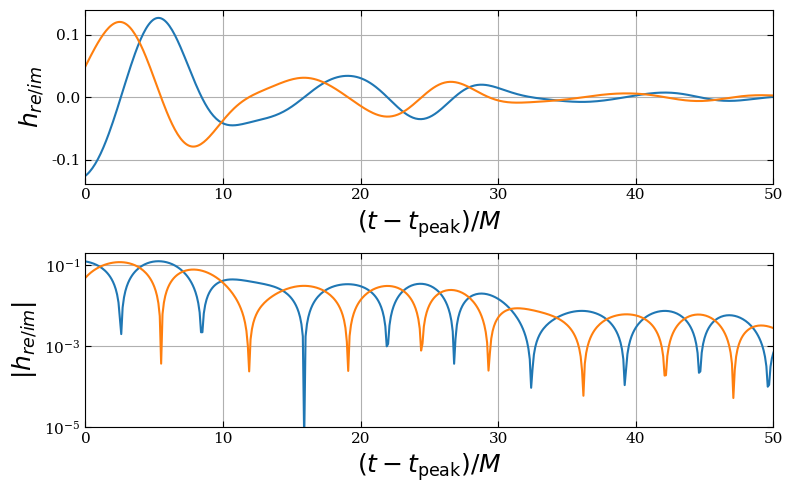

In [17]:
fig, ax = plt.subplots(2,1, figsize = (8, 5))
ax[0].plot(h.time, h.hr)
ax[0].plot(h.time, h.hi)
ax[1].semilogy(h.time, np.abs(h.hr))
ax[1].semilogy(h.time, np.abs(h.hi))
ax[0].set_xlim(0, 50)
ax[1].set_xlim(0, 50)
ax[1].set_ylim(0.00001, 0.2)

ax[0].set_ylabel(r'$h_{re/im}$')
ax[1].set_ylabel(r'$|h_{re/im}|$')
ax[0].set_xlabel(r'$(t - t_{\rm peak})/M$')
ax[1].set_xlabel(r'$(t - t_{\rm peak})/M$')
ax[0].grid()
ax[1].grid()
fig.tight_layout()

In [20]:
t0_arr = np.linspace(0,50,num=501)
N_free = 0
qnm_fixed_list = long_str_to_qnms("2.2.0_3.3.0", Mf, af) 
full_fit_fixed = QNMFitVaryingStartingTime(h, t0_arr, N_free, qnm_fixed_list, include_mirror=True,
                                           iota = iota, psi = psi, load_pickle= True,
                                     run_string_prefix=f"SXS{SXS_num}_summed_{iota:.4f}_{psi:.4f}_mirror")

In [21]:
full_fit_fixed.do_fits()

reloaded fit SXS1485_summed_1.0472_0.0000_mirror_N_0_fix_2.2.0_3.3.0_t0_0.0000_50.0000_501 from an old run.


In [22]:
fit_result = full_fit_fixed.result_full

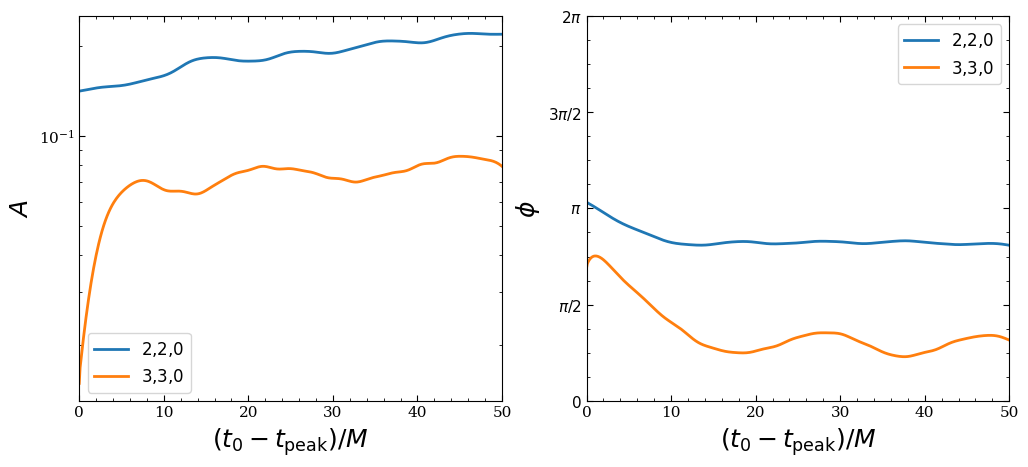

In [23]:
fig, axs = plt.subplots(1, 2, figsize = (12, 5))

plot_amplitudes(fit_result, fixed_modes=qnm_fixed_list, ax = axs[0])
plot_phases(fit_result, fixed_modes=qnm_fixed_list, ax = axs[1])

In [24]:
Q = fit_result.reconstruct_waveform(101, h.time)

In [25]:
h_recon = waveform(h.time, Q, t_peak = 0, remove_num = 0)

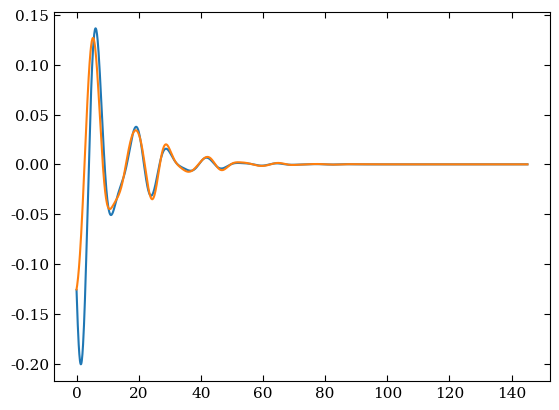

In [26]:
plt.plot(h_recon.time, h_recon.hr)
plt.plot(h.time, h.hr)
# plt.axvline(t0_arr[101])

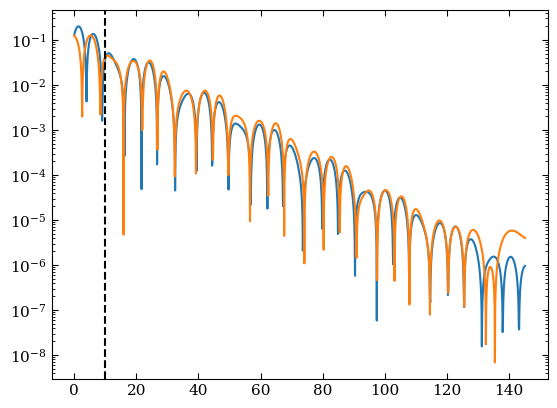

In [46]:
plt.semilogy(h_recon.time, np.abs(h_recon.hr))
plt.semilogy(h.time, np.abs(h.hr))
plt.axvline(10, color = 'k', linestyle = '--')

In [28]:
t0_arr = np.linspace(0,50,num=501)
N_free = 0
qnm_fixed_list = long_str_to_qnms("2.2.0", Mf, af) 
full_fit_fixed_recon = QNMFitVaryingStartingTime(h_recon, t0_arr, N_free, qnm_fixed_list, include_mirror=True,
                                           iota = iota, psi = psi, load_pickle= True,
                                     run_string_prefix=f"SXS{SXS_num}_recon_2.2.0_3.3.0_summed_{iota:.4f}_{psi:.4f}_mirror")

In [29]:
full_fit_fixed_recon.do_fits()

reloaded fit SXS1485_recon_2.2.0_3.3.0_summed_1.0472_0.0000_mirror_N_0_fix_2.2.0_t0_0.0000_50.0000_501 from an old run.


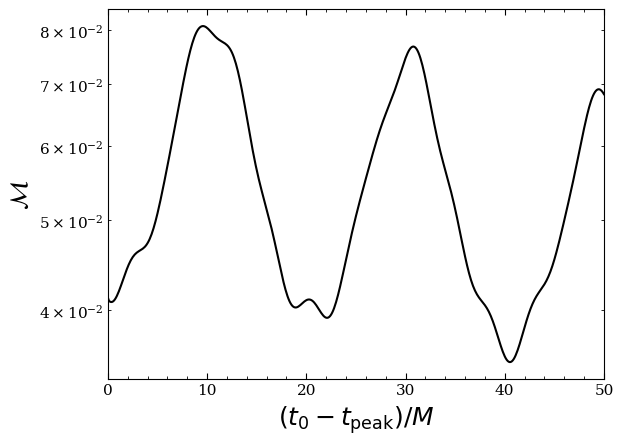

In [30]:
plot_mismatch(full_fit_fixed_recon.result_full)

5.475543510163472

In [32]:
import numpy as np

In [33]:
t0_arr = np.linspace(0,50,num=501)
N_free = 0
qnms_free = long_str_to_qnms_free("2.2.0")
full_fit_fixed_recon = QNMFitVaryingStartingTime(h_recon, t0_arr, N_free, qnm_fixed_list,
                                                  include_mirror=True, var_M_a = True,
                                           iota = iota, psi = psi, load_pickle= True,
                                     run_string_prefix=f"SXS{SXS_num}_recon_2.2.0_3.3.0_summed_{iota:.4f}_{psi:.4f}_mirror_varMa_")

In [34]:
full_fit_fixed_recon.do_fits()

501it [02:50,  2.94it/s]


In [35]:
varma_result = full_fit_fixed_recon.result_full

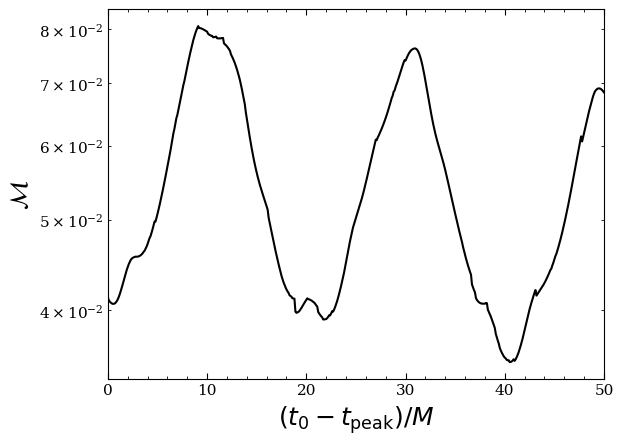

In [36]:
plot_mismatch(varma_result)

In [39]:
def mismatch_to_SNR(mismatch, log_B = 1):
    return np.sqrt(log_B/((1-(1-mismatch)**2)/2)*np.log(10))

In [44]:
mismatch_to_SNR(0.08, log_B = 1)

5.475543510163472